# Mito Clones 

Using vireo for clonal reconstruction - mitochondrial mutations

Date: 28/03/2021

The mitochondrial mutations data set is extracted from [Ludwig et al, Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.022), the 9 variants used here are from Supp Fig. 2F (and main Fig. 2F).

Generally, you can use [cellSNP-lite](https://github.com/single-cell-genetics/cellsnp-lite) to genotype mitochondrial genomes and call clonal informed mtDNA variants with [MQuad](https://github.com/single-cell-genetics/MQuad).

With the filtered variants at hand, we can use the `vireoSNP.BinomMixtureVB` class to reconstruct the clonality.

In [1]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt

print(vireoSNP.__version__)

0.5.5


In [2]:
# np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

In [3]:
AD = mmread("../data/mitoDNA/cellSNP.tag.AD.mtx").tocsc()
DP = mmread("../data/mitoDNA/cellSNP.tag.DP.mtx").tocsc()
# mtSNP_ids = np.genfromtxt('../data/mitoDNA/passed_variant_names.txt', dtype='str')

## Identify clones

In [4]:
from vireoSNP import BinomMixtureVB

In [5]:
_model = BinomMixtureVB(n_var=AD.shape[0], n_cell=AD.shape[1], n_donor=3)
_model.fit(AD, DP, min_iter=30, n_init=50)
print(_model.ELBO_iters[-1])

-190779.74335041404


##### Check the model fitting

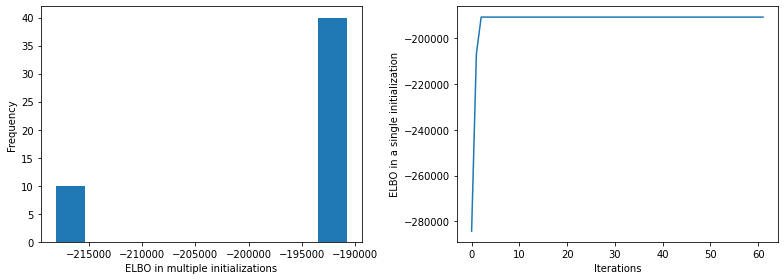

In [6]:
fig = plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.hist(_model.ELBO_inits)
plt.ylabel("Frequency")
plt.xlabel("ELBO in multiple initializations")

plt.subplot(1, 2, 2)
plt.plot(_model.ELBO_iters)
plt.xlabel("Iterations")
plt.ylabel("ELBO in a single initialization")

plt.tight_layout()
plt.show()

##### Visualize assignment probability and allele frequency

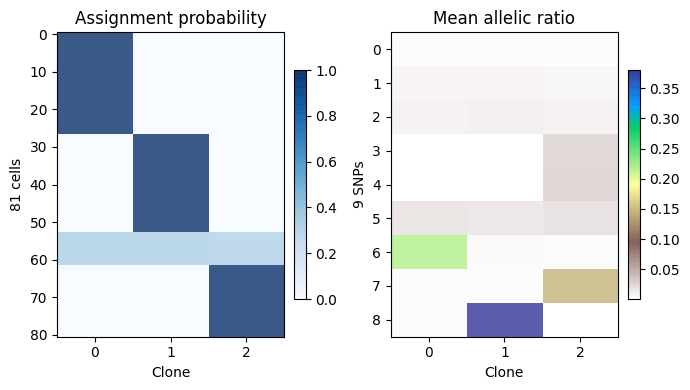

In [7]:
from vireoSNP.plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(_model.ID_prob, cmap="Blues", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(_model.n_cell))
plt.xticks(range(_model.n_donor))


plt.subplot(1, 2, 2)
im = heat_matrix(_model.beta_mu, cmap="terrain_r", alpha=0.8, 
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(_model.n_var))
plt.xticks(range(_model.n_donor))

plt.tight_layout()
plt.show()
# plt.savefig("you_favorate_path with png or pdf")

## Diagnosis

#### Double check if global optima is found
We are using multiple initializations via `n_init` and choose the one with highest ELBO. However, this doesn't guarantee to be the global optima. To double check it, we can run the same scripts multiple time (without fixed random seed), and check if the same (best) ELBO is found.

If yes, it is likely to be the global optima, otherwise, we need increase `n_init`, e.g., 300 for more search.

In [8]:
n_init = 50
for i in range(3):
    _model = BinomMixtureVB(n_var=AD.shape[0], n_cell=AD.shape[1], n_donor=3)
    _model.fit(AD, DP, min_iter=30, n_init=n_init)
    print("rerun %d:" %i, _model.ELBO_iters[-1])

rerun 0: -190779.74335041404
rerun 1: -190779.74335041404
rerun 2: -190779.74335041404


#### Identify the suitable number of clones

It is generally difficult to identify the number of clones, which is a balance between subclone resolution and analysis reliability. More clones maybe preferred, but there could be higher risk that the subclones are not genuine but rather technical noise.

Here, we could use ELBO for different number of clones as an indictor for model selection. However, this is still imperfect. One empirical suggestion is to choose the `n_clones` when ELBO stops increasing dramatically, for example in the case below, we will pick 3 clones.

In [9]:
n_init = 50
n_clone_list = np.arange(2, 6)

_ELBO_mat = []
for k in n_clone_list:
    _model = BinomMixtureVB(n_var=AD.shape[0], n_cell=AD.shape[1], n_donor=k)
    _model.fit(AD, DP, min_iter=30, n_init=n_init)
    _ELBO_mat.append(_model.ELBO_inits)

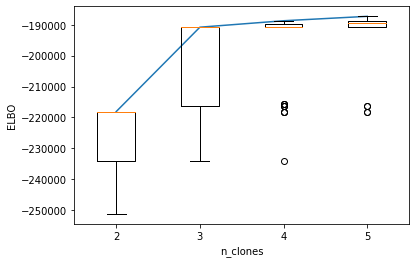

In [10]:
plt.plot(np.arange(1, len(n_clone_list)+1), np.max(_ELBO_mat, axis=1))
plt.boxplot(_ELBO_mat)
plt.xticks(np.arange(1, len(n_clone_list)+1), n_clone_list)
plt.ylabel("ELBO")
plt.xlabel("n_clones")
plt.show()

## Visualization

If you want to visualise the raw allele frequency with annotation of cells, you may consider [seaborn.clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html). We also wrap this function here as `vireoSNP.plot.anno_heat` for quick use.

In [11]:
mtSNP_ids = ['mt_variant%d' %x for x in range(AD.shape[0])]
cell_label = np.array(['clone1'] * 27 + ['clone2'] * 27 + ['clone3'] * 27)
id_uniq = ['clone1', 'clone2', 'clone3']

/Users/yuanhua/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


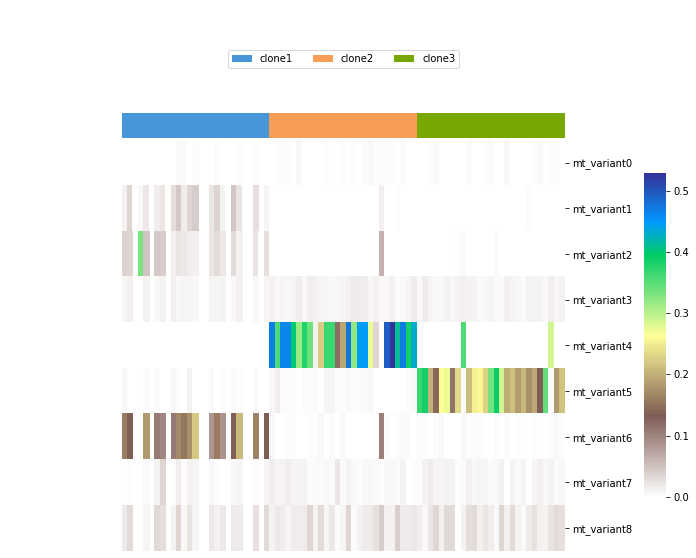

In [12]:
vireoSNP.plot.anno_heat(AD/DP, col_anno=cell_label, col_order_ids=id_uniq, 
                        cmap="terrain_r", yticklabels=mtSNP_ids)